In [1]:
import datetime
import weatherMethods
import timeMethods
from imp import reload
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tools import press, proxilvl
import pickle
from sklearn.neighbors import KDTree, BallTree, NearestNeighbors
from scipy.spatial import cKDTree
%matplotlib inline

## Debug weatherMethods

In [4]:
# UTC Flight Departure Time
departureTime = datetime.datetime(2013, 2, 4, 18, 50)
arrivalTime = datetime.datetime(2013, 2, 4, 20, 30)
print(departureTime)

# This function downloads all the data needed for the flight
WindClass = weatherMethods.GetWindSpeed(departureTime, arrivalTime)
# meteoDT, winds, lvls, valid_timeTags

#Current position
lon = -90
lat = 43
# Current altitude (ft)
alt = 30000

# UTC time at currentpostion
t = datetime.datetime(2013, 2, 4, 20, 15)

# Last position
lonl = -89.9
latl= 43.1
# This function gives wind value at current position (km/h)
wind  = WindClass.getWind(lon, lat, alt, t, lonl, latl)
print(wind)

2013-02-04 18:20:00
17.4573386555


In [5]:
WindClass.final_timeTags

['000', '001', '002']

## Wind Visualization

In [173]:
# create figure and axes instances
def PlotWind(Winds, AirPressure, Resolution = 120, Scale = 2500,Time = '02/04/2013 19:00 Zulu'):
    fig = plt.figure(figsize=(16,12))
    plt.title('Wind Speed (km/h), ' + Time + '. Elevation: ' + str(AirPressure) + ' mbar')
    # create polar stereographic Basemap instance.
    latlb = 21
    latub = 50
    lonlb = -127
    lonub = -67
    m = Basemap(projection='merc',llcrnrlat = latlb, urcrnrlat = latub, llcrnrlon = lonlb,urcrnrlon = lonub)
#     m.bluemarble()
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines(linewidth=1)
    m.drawstates(linewidth=0.25)
    m.drawcountries(linewidth=1)
    # m.drawmeridians(np.arange(-120,-80,10))
    # m.drawparallels(np.arange(10,50,5))
    
    u_wind = Winds[0][0][WindClass.lvls[AirPressure]].data(lat1 = latlb, lat2 = latub,lon1 = lonlb, lon2 = lonub)
    v_wind = Winds[0][1][WindClass.lvls[AirPressure]].data(lat1 = latlb, lat2 = latub,lon1 = lonlb, lon2 = lonub)

    u = u_wind[0]
    v = v_wind[0]
    x = u_wind[2]
    y = u_wind[1]
    z = np.sqrt(u**2 + v**2)
    
    xi = np.linspace(min(x), max(x), 30)
    yi = np.linspace(min(y), max(y), 30)
    ui = griddata((x, y), u, (xi[None,:], yi[:,None]), method='linear')
    vi = griddata((x, y), v, (xi[None,:], yi[:,None]), method='linear')
    xi,yi = m(xi,yi)
    Q = plt.quiver(xi,yi,ui,vi, scale = Scale, zorder = 10)
    

    xii = np.linspace(min(x), max(x), Resolution)
    yii = np.linspace(min(y), max(y), Resolution)
    zi = griddata((x, y), z, (xii[None,:], yii[:,None]), method='linear')

    xii, yii = m(xii,yii)
    CS = plt.contourf(xii,yii,zi,30,cmap=plt.cm.jet, zorder = 0)

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(CS, cax=cax)
    cb.set_label('km/h')
    qk = plt.quiverkey(Q, 0, 0, 100, '100 km/hr', labelpos='W', color = 'r', labelcolor='k')
    
    return xii,yii,zi

In [161]:
# UTC Flight Departure Time
departureTime = datetime.datetime(2013, 2, 4, 18, 50)
arrivalTime = datetime.datetime(2013, 2, 4, 20, 30)
print(departureTime)

# This function downloads all the data needed for the flight
WindClass = weatherMethods.GetWindSpeed(departureTime, arrivalTime)
Winds = WindClass.winds

2013-02-04 18:50:00


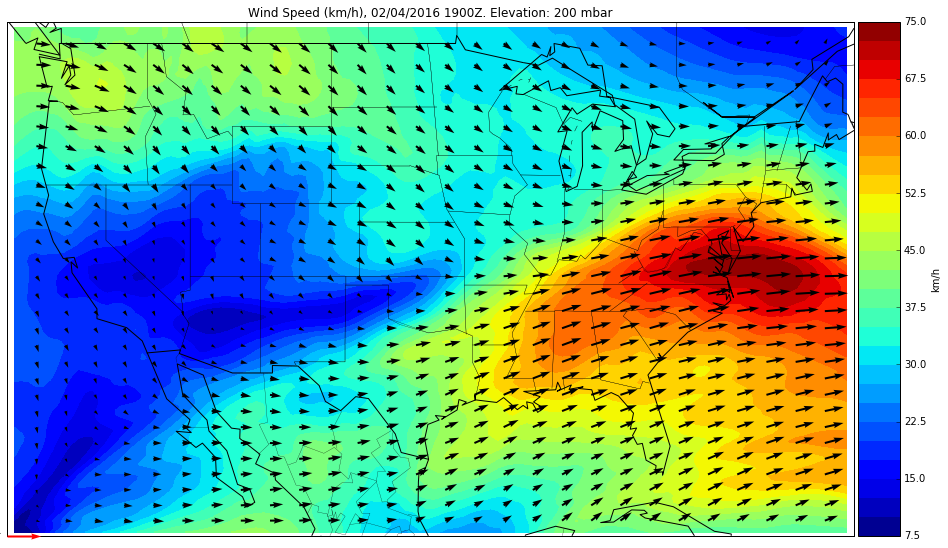

In [168]:
m = PlotWind(Winds, 200, Time = '02/04/2016 1900Z')
# 38000 ft

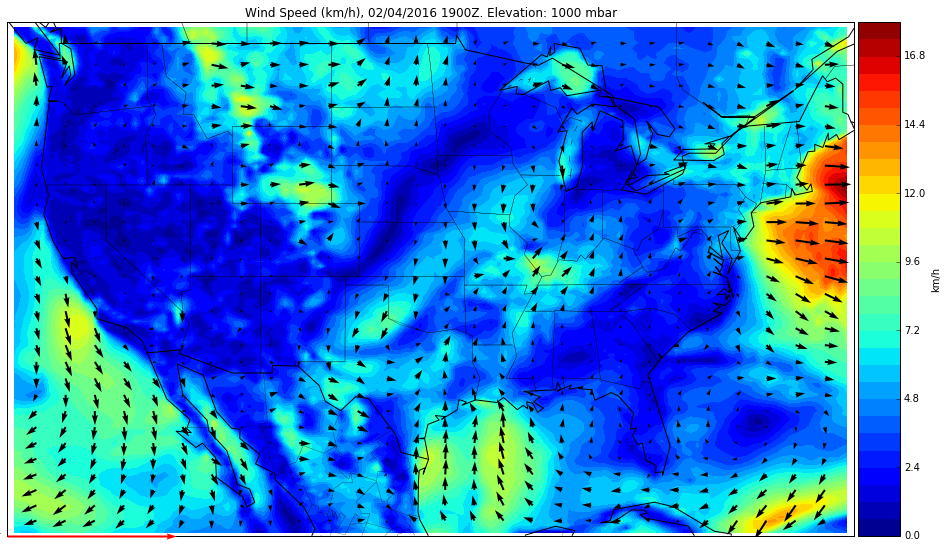

In [174]:
m1 = PlotWind(Winds, 1000, Scale = 500,Time = '02/04/2016 1900Z')

In [116]:
departureTime = datetime.datetime(2013, 1, 1, 18, 50)
arrivalTime = datetime.datetime(2013, 1, 1, 20, 30)
# This function downloads all the data needed for the flight
WindClass = weatherMethods.GetWindSpeed(departureTime, arrivalTime)
Winds = WindClass.winds

In [117]:
WindClass.lvls.keys()

dict_keys([450, 900, 325, 775, 200, 650, 75, 525, 975, 400, 850, 275, 725, 150, 600, 475, 925, 350, 800, 225, 675, 100, 550, 1000, 425, 875, 300, 750, 175, 625, 50, 500, 950, 375, 825, 250, 700, 125, 575])

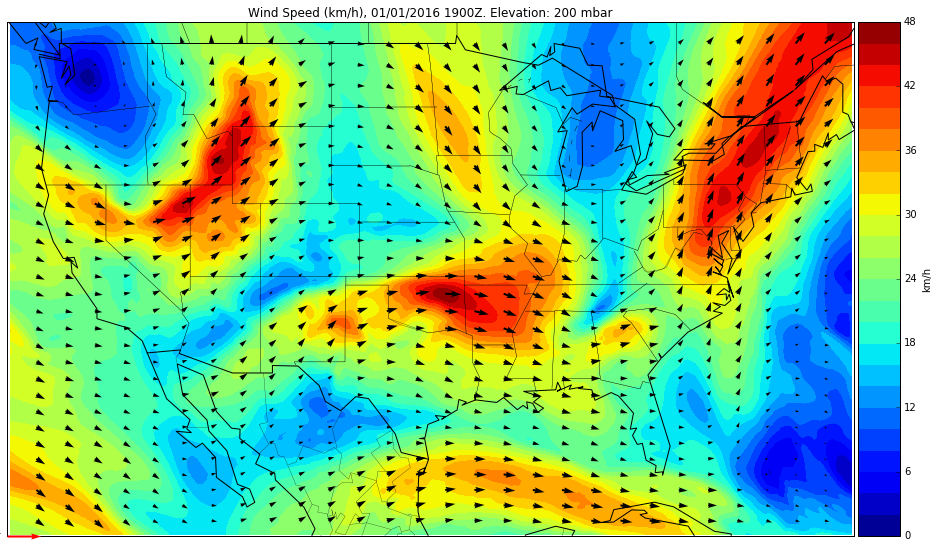

In [118]:
m2 = PlotWind(Winds, 200, Time = '01/01/2016 1900Z')

## Test on Trajectory Matching

In [2]:
VTrackPath = os.getcwd() + '/TFMS_NEW/New_IAHBOS2013.csv'
VTrack = pd.read_csv(VTrackPath, parse_dates=[6])

In [100]:
VTrack.head()

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist,Pressure
0,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:08:00,29.983333,-95.300000,8,159,471666-UAL386,0.0,0.000000,0.000000,0.000000,975
1,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:09:00,30.016667,-95.266667,26,253,471666-UAL386,60.0,2.647485,0.044125,2.647485,925
2,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:11:00,30.166667,-95.233333,86,300,471666-UAL386,120.0,9.170856,0.076424,11.818341,725
3,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:12:00,30.250000,-95.216667,109,300,471666-UAL386,60.0,5.077461,0.084624,16.895802,675
4,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:13:00,30.366667,-95.183333,130,334,471666-UAL386,60.0,7.214531,0.120242,24.110333,625


In [128]:
Sample = VTrack[VTrack.FID == 20130101632288]

In [129]:
Sample.head(3)

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist,Pressure
0,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:08:00,29.983333,-95.300000,8,159,471666-UAL386,0.0,0.000000,0.000000,0.000000,975
1,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:09:00,30.016667,-95.266667,26,253,471666-UAL386,60.0,2.647485,0.044125,2.647485,925
2,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:11:00,30.166667,-95.233333,86,300,471666-UAL386,120.0,9.170856,0.076424,11.818341,725


In [135]:
a = VTrack.Alt.values
b = np.roll(a,1)
c = abs(b-a)
np.where(c > 200)

(array([ 93277,  93278, 155078, 155079, 160260, 160262, 160640, 160641,
        183211, 190806, 190807, 247957, 247958]),)

In [158]:
VTrack.ix[183211,'FID']

20130811346449

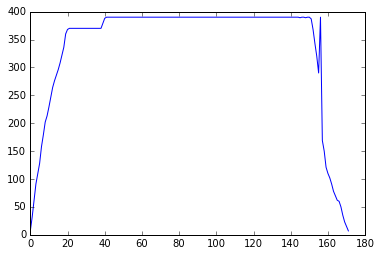

In [156]:
plt.plot(VTrack[VTrack.FID == VTrack.ix[183211,'FID']].Alt.values)

In [148]:
VTrack[VTrack.FID == VTrack.ix[93277,'FID']].tail(5)

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist
93273,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:14:00,42.233333,-70.883333,36,238,148108-N598WC,60.0,4.070687,0.067845,1476.083206
93274,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:15:00,42.283333,-70.916667,24,180,148108-N598WC,60.0,3.347505,0.055792,1479.430711
93275,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:16:00,42.316667,-70.950000,10,123,148108-N598WC,60.0,2.489243,0.041487,1481.919954
93276,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:17:00,42.350000,-70.983333,5,162,148108-N598WC,60.0,2.488777,0.041480,1484.408731
93277,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:19:00,42.433333,-71.066667,230,162,148108-N598WC,120.0,6.219902,0.051833,1490.628633


In [9]:
st = time.time()
depTime = Sample.Elap_Time.iloc[0]
arrTime = Sample.Elap_Time.iloc[-1]

Position = Sample[['Lat','Lon','Alt']].values
Position[:,2] = Position[:,2] * 100
TimeStamp = Sample.Elap_Time

WindClass = weatherMethods.GetWindSpeed(depTime, arrTime)
lastPos = Position[0]

WindSpeed = [0]
for idx in range(Position.shape[0] - 1):

    curPos = Position[idx + 1]
    curTime = TimeStamp.iloc[idx+1]
    wind  = WindClass.getWind(curPos[1], curPos[0], curPos[2], curTime,lastPos[1], lastPos[0])
    WindSpeed.append(wind)
    lastPos = curPos
    
print(time.time() - st)

45.548314571380615


In [ ]:
Sample['WindSpeed'] = 0
Sample.loc[1:,'WindSpeed'] = np.array(WindSpeed)
Sample['AirSpeed'] = Sample.GroundSpeed * 1.852 - Sample.WindSpeed
Sample['WindDist'] = Sample.AirSpeed * Sample.DT /3600 * 0.539957

In [145]:
print(sum(Sample.WindDist))
print(sum(Sample.Dist))

1260.33594474
1460.54414964


In [87]:
pickle.dump(Winds[0][0][WindClass.lvls[uniquelvl[i]]].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967), 
            open('test.p','wb'))

In [91]:
getsizeof(Winds[0][0][WindClass.lvls[uniquelvl[i]]].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967))

72

## Try nearest neighbor

In [28]:
VTrackPath = os.getcwd() + '/TFMS_NEW/New_IAHBOS2013.csv'
VTrack = pd.read_csv(VTrackPath, parse_dates=[6])
Sample = VTrack[VTrack.FID == 20131231490984]

In [27]:
VTrack.FID.unique()

array([20130101632288, 20130101635086, 20130101663353, ..., 20131231490984,
       20131231518394, 20131231523303])

In [29]:
st = time.time()
depTime = Sample.Elap_Time.iloc[0]
arrTime = Sample.Elap_Time.iloc[-1]

Position = Sample[['Lat','Lon','Alt']].values
Position[:,2] = Position[:,2] * 100

WindClass = weatherMethods.GetWindSpeed(depTime, arrTime)
print(time.time() - st)

uniquelvl = []

for i in range(Position.shape[0]):
    alt = Position[i,2]
    pro_lvl = proxilvl(alt,WindClass.lvls)
    Position[i,2] = pro_lvl
    if pro_lvl not in uniquelvl:
        uniquelvl.append(pro_lvl)
    else:
        pass
print(time.time() - st)

Winds = WindClass.winds
for i in range(len(uniquelvl)):
    u_wind = Winds[0][0][WindClass.lvls[uniquelvl[i]]].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.82)
    v_wind = Winds[0][1][WindClass.lvls[uniquelvl[i]]].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.82)
    
    u_windspeed = u_wind[0]
    lat = u_wind[1]
    lon = u_wind[2]
    pres_lvl = np.ones(lat.shape) * uniquelvl[i]
    v_windspeed = v_wind[0]

    if i == 0:
        wind_array = np.dstack((lat, lon, pres_lvl, u_windspeed, v_windspeed))[0]

    else:
        temp_wind = np.dstack((lat, lon, pres_lvl, u_windspeed, v_windspeed))[0]
        wind_array = np.append(wind_array, temp_wind, axis = 0)

print(time.time() - st)
tree = cKDTree(wind_array[:,:3], leafsize = 100)
print(time.time() - st)
_, near_idx = tree.query(Position[:,:3], k = 1)
wind_vector = wind_array[near_idx,3:]
print(time.time() - st)

3.1299631595611572
3.13470458984375
6.281351327896118
9.200257301330566
9.201108932495117


In [24]:
wind_array.shape

(708312, 5)

In [16]:
%timeit KDTree(wind_array[:50000,:3], leaf_size = 100)

1 loop, best of 3: 819 ms per loop


In [18]:
%timeit cKDTree(wind_array[:100000,:2])

10 loops, best of 3: 34.5 ms per loop


In [19]:
%timeit cKDTree(wind_array[:500000,:2])

1 loop, best of 3: 282 ms per loop


In [69]:
tree = cKDTree(wind_array[:500000,:3])

In [70]:
tree.query(Position[:,:3])

(array([  1.19722732e-01,   8.34861902e-02,   6.83602002e-02,
          3.90283925e-02,   2.84158084e-02,   3.91295188e-02,
          2.76888828e-02,   4.44320916e-02,   2.11209281e-02,
          7.12010523e-02,   4.03055815e-02,   6.06732243e-02,
          5.55842678e-02,   2.89549891e-02,   4.81401081e-02,
          3.50073789e-02,   2.92577026e-02,   6.65533505e-02,
          6.65560510e-02,   2.57067016e-02,   6.42973692e-02,
          4.12307564e-02,   4.69480237e-02,   5.70175891e-02,
          4.07589801e-02,   2.46747043e-02,   1.44113376e-02,
          4.98567591e-03,   2.18337222e-02,   2.63814482e-02,
          4.46184940e-02,   5.11644994e-02,   5.90668608e-02,
          7.66321001e-02,   4.69621060e-02,   7.77186730e-02,
          3.73073688e-02,   3.02968942e-02,   9.54028896e-03,
          1.17681274e-02,   1.11789945e-02,   3.29415071e-02,
          3.30271324e-02,   4.05291500e-02,   6.28338934e-02,
          6.11347058e-02,   6.75914798e-02,   7.62892350e-02,
        

In [53]:
Position

array([[   29.98333333,   -95.3       ,   975.        ],
       [   30.01666667,   -95.26666667,   925.        ],
       [   30.16666667,   -95.23333333,   725.        ],
       [   30.25      ,   -95.21666667,   675.        ],
       [   30.36666667,   -95.18333333,   625.        ],
       [   30.46666667,   -95.15      ,   575.        ],
       [   30.56666667,   -95.08333333,   500.        ],
       [   30.68333333,   -95.01666667,   475.        ],
       [   30.78333333,   -94.95      ,   425.        ],
       [   30.91666667,   -94.86666667,   400.        ],
       [   31.03333333,   -94.8       ,   375.        ],
       [   31.16666667,   -94.71666667,   350.        ],
       [   31.28333333,   -94.63333333,   325.        ],
       [   31.4       ,   -94.55      ,   325.        ],
       [   31.53333333,   -94.46666667,   300.        ],
       [   31.65      ,   -94.38333333,   275.        ],
       [   31.78333333,   -94.28333333,   275.        ],
       [   31.91666667,   -94.2

In [31]:
tree = KDTree(u_wind_array[:,:2], leaf_size = 30)              
near_idx = tree.query(Position[:,:2], k = 1, dualtree = False, return_distance = False)

In [35]:
%timeit tree = KDTree(u_wind_array[:,:2], leaf_size = 30)  

1 loop, best of 3: 436 ms per loop


In [180]:
%timeit near_idx = tree.query(Position[:,:2], k = 1, dualtree = False, return_distance = False)

The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 359 µs per loop


In [36]:
a = Winds[0][0][WindClass.lvls[uniquelvl[i]]].data

In [61]:
a(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967)[2].shape

(21333,)

In [74]:
from shapely.geometry import LineString, Polygon, Point, MultiPoint

In [69]:
line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
dilated = line.buffer(0.5)

In [77]:
dilated.intersects(MultiPoint([(0, 0), (100, 10)]))

True

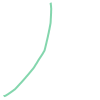

In [97]:
LineString(Position[:,:2])

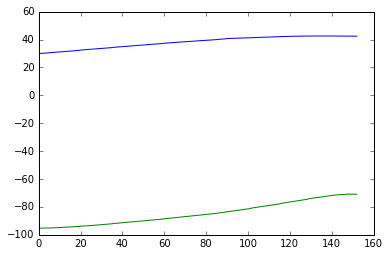

In [93]:
plt.plot(LineString(Position[:,:2]))

In [20]:
from weather.gributils import *

In [21]:
path = '/media/liuyulin101/YulinLiu/WindData'
datasrc = path + '/DATA/filtered_weather_data/namanl'

In [22]:
def ReadWind(fname):
    grbs = pygrib.open(fname)
    uin = grbs.select(shortName='u', typeOfLevel='isobaricInhPa')
    vin = grbs.select(shortName='v', typeOfLevel='isobaricInhPa')
    grbs.close()
    return (uin, vin)


In [24]:
st = time.time()
path = '/media/liuyulin101/YulinLiu/WindData/DATA/filtered_weather_data/namanl/'
i = 0
WindDict = {}
for filtered_wind in os.listdir(path):
    i += 1
    fname = path + filtered_wind
#     if i <= 5:
#         WindDict[filtered_wind[11:28]] = ReadWind(fname)
#     else:
#         break
time.time() - st

5.548418998718262

In [228]:
for k in range(1,2):
    print(k)

1


In [212]:
fname = '/media/liuyulin101/YulinLiu/WindData/DATA/filtered_weather_data/namanl/namanl_218_20130923_1800_000.grb'

In [229]:
k = os.listdir('/media/liuyulin101/YulinLiu/WindData/DATA/filtered_weather_data/namanl')

In [231]:
[1,2,3,4,5][2:]

[3, 4, 5]

In [224]:
%timeit fname[-32:] in k

The slowest run took 4.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 125 µs per loop


In [213]:
%timeit pygrib.open(fname)

The slowest run took 43.98 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 33.4 ms per loop


In [87]:
for grb in grbs:
    grb

In [105]:
grbs.select(maximum =, shortName='u', typeOfLevel='isobaricInhPa')

ValueError: no matches found

In [25]:
import pickle

In [31]:
picklefile = open('WindDictionary.p','w')
pickle.dump(WindDict, picklefile)
picklefile.close()

RuntimeError: b'Key/value not found'

In [110]:
%timeit grbs = pygrib.open(path + filtered_wind)

The slowest run took 35.73 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 49.6 ms per loop


In [ ]:
%timeit uin = grbs.select(shortName='u', typeOfLevel='isobaricInhPa')